# Welcome to my (attempted) Start-Up Viability Predictor

1) Import all necessary libraries

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline

2) Import both necessary data sets and label them appropriately

a) first, import and format the start-up dataset

This is a dataset of almost 50k startups and their funding processes and whether or not they currently exist today. This is the data that I will train my model on.

In [2]:
investments_url = "investments_VC.csv"
df = pd.read_csv(investments_url, encoding ="latin1")

#fix column names
df['market'] = df[' market ']
df['funding_total_usd'] = df[' funding_total_usd ']

df = df.drop(['name', 'homepage_url', 'permalink', 'state_code',  ' market ',' funding_total_usd ', 'category_list'], axis=1)
df = df.drop(['round_A','round_B','round_C','round_D','round_E' ,'round_F','round_G' ,'round_H'], axis=1)
df = df.drop(['debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding'], axis=1)
df = df.drop(['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'founded_month', 'founded_quarter'], axis=1)

df=df.dropna(subset=['status','funding_total_usd','founded_at'])
df = df.drop(df[df.funding_total_usd == '-'].index)

df['fund1']=df['first_funding_at'].str.slice(0,7)
df['fundLast']=df['last_funding_at'].str.slice(0,7)
df['found']=df['founded_at'].str.slice(0,7)
df = df.drop(['first_funding_at','last_funding_at','founded_at' ,'founded_year', 'region'], axis=1)

df.head(5)

,status,country_code,city,funding_rounds,market,funding_total_usd,fund1,fundLast,found
0,acquired,USA,New York,1.0,News,"17,50,000",2012-06,2012-06,2012-06
2,operating,EST,Tallinn,1.0,Publishing,"40,000",2012-08,2012-08,2012-10
3,operating,GBR,London,1.0,Electronics,"15,00,000",2011-04,2011-04,2011-04
4,operating,USA,Fort Worth,2.0,Tourism,"60,000",2014-08,2014-09,2014-01
7,operating,NaN,NaN,1.0,Curated Web,"20,00,000",2008-03,2008-03,2007-01


b) then, import and format the consumer price index information

This information will be cross-refernced with the important "life-cycle" dates of the start-ups. This model will try to analyze the start-ups by the CPI when they were founded, when they raised their first round of funding, and when they raised their last round of funding

In [3]:
CPI_url = 'https://pkgstore.datahub.io/core/cpi-us/cpiai_csv/data/b17bfacbda3c08e51cd13fe544b8fca4/cpiai_csv.csv'
df2 = pd.read_csv(CPI_url)

#### Cross reference the notable dates with the CPI on those dates

In [4]:
df2['month_year'] = pd.to_datetime(df2['Date']).dt.to_period('M')
df2['fund1']=df2['month_year'].astype(str)
df2['Index_firstFunding'] = df2['Index']
df2 = df2.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

In [5]:
df3 = pd.read_csv(CPI_url)
df3['month_year'] = pd.to_datetime(df3['Date']).dt.to_period('M')
df3['fundLast']=df3['month_year'].astype(str)
df3['Index_lastFunding'] = df3['Index']
df3 = df3.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

In [6]:
df4 = pd.read_csv(CPI_url)
df4['month_year'] = pd.to_datetime(df4['Date']).dt.to_period('M')
df4['found']=df4['month_year'].astype(str)
df4['Index_found'] = df4['Index']
df4 = df4.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

### Merge everything onto one dataframe (and print the top so we can see how nicely it came out!)

In [7]:
df = pd.merge(df, df2, how='left', on = 'fund1')
df=df.dropna(subset=['Index_firstFunding'])

df = pd.merge(df, df3, how='left', on = 'fundLast')
df=df.dropna(subset=['Index_lastFunding'])

df = pd.merge(df, df4, how='left', on = 'found')
df=df.dropna(subset=['Index_found'])

df["label"] = df["status"]
df = df.drop(['status', 'fund1', 'fundLast', 'funding_total_usd', 'found'], axis=1)

df.head(10)

,country_code,city,funding_rounds,market,Index_firstFunding,Index_lastFunding,Index_found,label
0,USA,New York,1.0,News,229.478,229.478,229.478,acquired
1,EST,Tallinn,1.0,Publishing,230.379,230.379,231.317,operating
2,GBR,London,1.0,Electronics,224.906,224.906,224.906,operating
3,NaN,NaN,1.0,Curated Web,213.528,213.528,202.416,operating
4,CHL,Las Condes,1.0,E-Commerce,232.166,232.166,226.665,operating
5,USA,Los Angeles,1.0,Health and Wellness,218.312,218.312,109.600,operating
6,USA,Iselin,1.0,Health and Wellness,223.467,223.467,101.900,operating
7,USA,Orlando,1.0,Real Estate,233.916,233.916,233.049,operating
8,USA,Woodbine,4.0,E-Commerce,215.693,225.672,175.100,operating
9,USA,Lake Oswego,1.0,Search,226.545,226.545,211.080,operating


    Drop all rows that have NaN in the "label" column because these data points won't be useful to us

In [8]:
dfRegression=df.dropna(subset=['label'])

    Use OneHotEncoder to convert the "market" and "country_code" columns to usable data.
    These columns (hopefully) contain useful data that we want to extract for our model to use.
    OneHotEncoder makes the data that comes as strings useful for our model that only accepts numerical data.

In [9]:
from sklearn.preprocessing import OneHotEncoder

Encode = OneHotEncoder(handle_unknown = 'ignore').fit(dfRegression[['market', 'country_code']])

TrainEncode = pd.DataFrame(Encode.transform(dfRegression[['market', 'country_code']]).toarray())

dfRegression = dfRegression.join(TrainEncode)

dfRegression = dfRegression.drop(['city', 'market', 'country_code'], axis=1)

In [10]:
dfRegression = dfRegression.dropna()

The "Data" is everthing in the DataFrame minus the labels! This will become the "X" we will train and test with!

In [11]:
dfRegressionData = dfRegression.drop(['label'], axis=1)

X = dfRegressionData

Import NLTK: (for the record - this took me over 3 hours of troubleshooting)

In [12]:
!pip3 install nltk
import nltk
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to /home/jupyter-tk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Tokenize the "labels" then binarize the "labels". This will become the "y" that we train and test with!

In [13]:
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MultiLabelBinarizer

dfRegression["label"] = dfRegression["label"].apply(word_tokenize)
y = dfRegression["label"]

mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(y))

In [14]:
print(mlb.classes_)

['acquired' 'closed' 'operating']


Important to split into training and testing sets!

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Pre-Processing Pipeline (say that 5 times fast)
    1) Scale Values
    2) Run Principal Component Analysis (to reduce dimensionality)
    3) Run Random Forest Regressor model
    
It is good to have this in a pipeline because whatever we do to the training set, we must do to the testing set!
This pipeline helps to keep us consistent!



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=.95)),
    ('model', RandomForestRegressor(n_estimators=3))
])

    How did I pick Random Forest you might ask?
    Great question!
    
    Random Forest is an example of a "bagging" algorithm
    This is because the different trees run in parallel to each other 
    This type of algorithm is a good algorithm for datasets that are imbalanced
    
    This is relevant here becuase there are way more examples of "operating" start-ups than "closed" start-ups in 
    the train/test data set 
    This obviously doesn't reflect how start-ups behave in the real world, so this bagging algorithm is my attempt 
    to get rid of this imbalance
    
    I made a LARGE number of estimators (i.e. trees) in order to prevent overfitting which was a big issue for me

### fit the pipeline (and the model!) :

#### sorry it takes so long to train! : /

According to my estimates it takes around 40 minutes to train. Maybe make a cup of coffee or two while you wait.

In [17]:
fitted = pipe.fit(X_train, y_train)

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## Let's check how the model did!

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

predictionsTrain = fitted.predict(X_train).round()
predictions = fitted.predict(X_test).round()

print("Train Report", classification_report(y_train, predictionsTrain))
print("Test Report", classification_report(y_test, predictions))

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Train Report               precision    recall  f1-score   support

           0       0.89      0.79      0.83      2154
           1       0.86      0.75      0.80      1475
           2       0.96      0.97      0.97     17156

   micro avg       0.95      0.94      0.94     20785
   macro avg       0.90      0.84      0.87     20785
weighted avg       0.95      0.94      0.94     20785
 samples avg       0.94      0.94      0.94     20785

Test Report               precision    recall  f1-score   support

           0       0.23      0.17      0.20       728
           1       0.14      0.11      0.13       489
           2       0.85      0.85      0.85      5712

   micro avg       0.75      0.72      0.74      6929
   macro avg       0.41      0.38      0.39      6929
weighted avg       0.73      0.72      0.73      6929
 samples avg       0.72      0.72      0.72      6929



/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is a confusion matrix of how accurate the model does when we predict on the data we trained on.

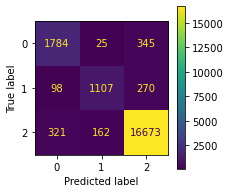

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(confusion_matrix(y_train.values.argmax(axis=1), predictionsTrain.argmax(axis=1))).plot(ax=ax)

This is a confusion matrix of how accurate the model does when we predict on new test data. If this is very different than the last confusion matrix it signifies that the model likely overfit (and we probably need more trees)

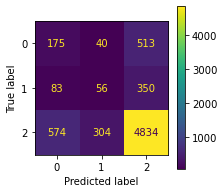

In [20]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))).plot(ax=ax)

#### This model is clearly far from perfect. If I had more time I would implement more ways to get rid of the inherent imbalance in the dataset. 

## Lets Predict With This Model!

### example prediction (you can fill in your own data!)
#### IMPORTANT!! The CPI Data only goes until the end of 2013 so putting in a later date will result in an error
##### obviously this is NOT ideal and I hope to find better CPI data before I sell this model for a billion dollars to a big VC firm in the near future! :) 

In [21]:
Market = 'Real Estate'
Country_code = 'USA'
Funding_rounds = '2'
fund1 = '2009-07'
fundLast = '2010-06'
found = '2009-01'

#### You can modify the data points above but please don't modify anything below this!

Create a DataFrame with the given data:

In [22]:
data = {"market": [Market], "country_code": [Country_code], "Rounds": [Funding_rounds], 
        "fund1": [fund1], "fundLast": [fundLast], "found":[found]}

predicting = pd.DataFrame(data)

print(predicting)

        market country_code Rounds    fund1 fundLast    found
0  Real Estate          USA      2  2009-07  2010-06  2009-01


Must do the same data preprocessing as with the train/test dataset (this means corss reference given dates with the CPI index on those dates!)

In [23]:
df2 = pd.read_csv(CPI_url)
df2['month_year'] = pd.to_datetime(df2['Date']).dt.to_period('M')
df2['fund1']=df2['month_year'].astype(str)
df2['Index_firstFunding'] = df2['Index']
df2 = df2.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

df3 = pd.read_csv(CPI_url)
df3['month_year'] = pd.to_datetime(df3['Date']).dt.to_period('M')
df3['fundLast']=df3['month_year'].astype(str)
df3['Index_lastFunding'] = df3['Index']
df3 = df3.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

df4 = pd.read_csv(CPI_url)
df4['month_year'] = pd.to_datetime(df4['Date']).dt.to_period('M')
df4['found']=df4['month_year'].astype(str)
df4['Index_found'] = df4['Index']
df4 = df4.drop(['Date', 'Inflation', 'Index','month_year'], axis=1)

predicting = pd.merge(predicting, df2, how='left', on = 'fund1')

predicting = pd.merge(predicting, df3, how='left', on = 'fundLast')

predicting = pd.merge(predicting, df4, how='left', on = 'found')

predicting = predicting.drop(['fund1', 'fundLast', 'found'], axis=1)

Run the SAME OneHotEncoding on this data to make the string data into usable numerical data (again, need to be consistent with the training data and the predicting data!)

In [24]:
from sklearn.preprocessing import OneHotEncoder

predict = pd.DataFrame(Encode.transform(predicting[['market', 'country_code']]).toarray())

predicting = predicting.drop(['market', 'country_code'], axis=1)

prediction = predicting.join(predict)

Scale, reduce dimensionality, and then predict on the same model as before.
That pipeline sure comes in handy!!

In [25]:
prediction = fitted.predict(prediction)

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Drum roll for the final prediction about the startup viability!

In [26]:
print(prediction)

[[0.66666667 0.         0.33333333]]


Thanks for reading! This project was very difficult but ultimately super rewarding! It was cool to see my idea work (somewhat) and to watch everything we learned this semester come together! Thank you!!